In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False


from filterLineSearchSparse import interior_pt
from hippylib import nb

from helperfunctions import *

In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

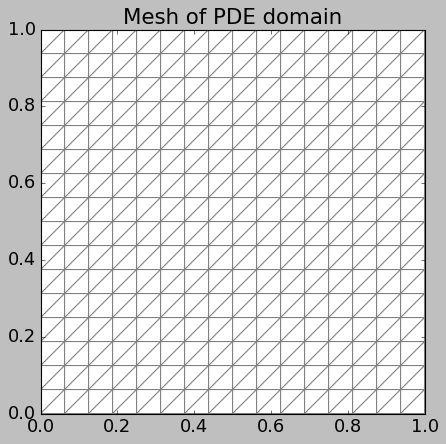

In [13]:
nx_coarse = 8 
nx = 16

# coarse and fine meshes
mesh_coarse = dl.UnitSquareMesh(nx_coarse, nx_coarse)

mesh_fine   = dl.UnitSquareMesh(nx, nx)

meshes = [mesh_coarse, mesh_fine]
mesh   = meshes[-1]
lvl    = len(meshes) # depth of mesh hierarchy
dl.plot(mesh)
plt.title('Mesh of PDE domain')
plt.show()

In [14]:
P1s  = [dl.FiniteElement("CG", meshes[i].ufl_cell(), 1) for i in range(lvl)]
Vh1s = [dl.FunctionSpace(meshes[i], P1s[i]) for i in range(lvl)]

In [15]:
class Boundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return (dl.near(x[0], 0.0) or dl.near(x[0], 1.0)) and on_boundary

As = [None for i in range(lvl)]
Ss = [None for i in range(lvl)]
bs = [None for i in range(lvl)]
for i, Vh1 in enumerate(Vh1s):
    test  = dl.TestFunction(Vh1)
    trial = dl.TrialFunction(Vh1)
    aform = dl.inner(dl.grad(test),dl.grad(trial))*dl.dx(Vh1.mesh())
    Lform = dl.Constant(1.0)*test*dl.dx(Vh1.mesh())
    bc    = dl.DirichletBC(Vh1, dl.Constant(0.0), Boundary())
    As[i], bs[i] = dl.assemble_system(aform, Lform, bc)
    As[i] = csr_fenics2scipy(As[i])
    bs[i] = bs[i][:]
    Ss[i] = sps.diags(0.66/As[i].diagonal())    

In [16]:
P = csr_fenics2scipy(\
         dl.PETScDMCollection.create_transfer_matrix(\
         Vh1s[0], Vh1s[1]))
R = P.transpose()

In [17]:
smoothing_steps = 1
two_grid_P = two_grid_action(As[1], As[0], Ss[1], P, R, smoothing_steps)

krylov_convergence = Krylov_convergence(As[1], bs[1])
krylov_convergence.reset()
lintol=1.e-8
maxiter=50



u, info = spla.gmres(As[1], bs[1], tol=lintol, atol=lintol, \
                   M = two_grid_P, maxiter=maxiter, callback=krylov_convergence.callback)
print("final residual = {0:1.2e} (two-grid with coarse grid correction)".format(np.linalg.norm(As[1].dot(u)-bs[1])))
residuals_twogrid = np.array(krylov_convergence.residuals).copy()
krylov_convergence.reset()

u, info = spla.gmres(As[1], bs[1], tol=lintol, atol=lintol, \
                   maxiter=maxiter, callback=krylov_convergence.callback)
print("final residual = {0:1.2e} (two-grid with no preconditioner)".format(np.linalg.norm(As[1].dot(u)-bs[1])))
residuals_noP = np.array(krylov_convergence.residuals).copy()

print(len(residuals_twogrid))
print(len(residuals_noP))

final residual = 7.69e-09 (two-grid with coarse grid correction)
final residual = 2.03e-05 (two-grid with no preconditioner)
9
50


In [18]:
ei = np.zeros(two_grid_P.shape[0])
PA = np.zeros(two_grid_P.shape)

for i in range(two_grid_P.shape[0]):
    ei[i] = 1.0
    PA[:,i] = two_grid_P._matvec(As[1].dot(ei))
    ei[i] = 0.0
condPA = np.linalg.cond(PA)
print(condPA)
print(np.linalg.cond(As[1].todense()))

2.1939153233156845
219.76433743750874
